# Prices EDA

In this Notebook, we're going to examine how time-series data is constructed and distributed. We know that gas stations in Germany are required to report any change in their petrol prices in (almost) real-time. This means that data isn't generated centrally but is decentralized across approximately 16,000 instances. We observe that the API creates some batched timestamps rather than a single timestamp for every observed price change, but this doesn't provide much help. We encounter three main issues with the data:

* It's not uniformly sampled, which means that not every timestamp represents each gas station. In fact, each timestamp includes only a relatively small number of price changes, although more than one.
* Timestamps aren't equidistant, which is to be expected as gas stations can change their prices at will and at any time. Sometimes prices change 10 times per hour, and sometimes only once a day.
* In addition to the irregular time-scale, there's no rule dictating when gas stations sell gas. They might be closed for an entire day, have varying opening hours, or never close at all. They might also run out of product and stop selling entirely.

We're trying to investigate the details of the outlined problems and find solutions to pre-process our data for a baseline model. Note that there are models capable of handling irregular data. We will explore these further down the line. However, in a first step, our goal is to resample the data as efficiently as possible and create a regular panel. To do this, we need to:

* Find reasonable time-bins for the report. If we make these too granular, the dataset will bloat exponentially, making it computationally unreasonable.
* If the bins are too large, we lose too much information. Our goal is to observe and predict impulse responses from neighboring gas stations. Large bins would falsely imply that events are happening simultaneously, which they aren't, as the data generation process (DGP) is decentralized.
* This process will create many sparse tables, which will need to be filled with the current prices of each gas station at each timestamp. These prices correspond to the last price the respective station set.

Especially the last point is quite unfortunate but necessary for classical models or "simpler" ML models to handle the data. However, it doesn't really add any information that wasn't in the original dataset, yet it needs to be computed. Our goal is to find a model that can handle this irregular data without the need for resampling. One way to tackle this could be the creation of time distances as features, which we will also investigate in this notebook.

In [37]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime as dt
import random

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path
from src.config.paths import ROOT_DIR, SAMPLE_DIR, PRICES_DIR

import src.fileutils as files
import src.visualization as viz
import src.process as process
import src.process_prices as pp
from src.process_files import PriceProcessor
from src.visualization import set_rc_params, set_plot_options

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
stations_info_file = ROOT_DIR / 'data' / 'stations.csv'

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

sns.set(style='darkgrid', palette='Spectral', color_codes=True)

In [8]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(context='paper', style='white', palette='Spectral', color_codes=True, rc=custom_params)

set_rc_params()

In [9]:
raw_prices = PriceProcessor(PRICES_DIR, SAMPLE_DIR)
raw_prices.get_sample(random_state=RSEED).head(5)


date  ... e10change
0  2018-02-05 00:01:06+01  ...         1
1  2018-02-05 00:03:05+01  ...         0
2  2018-02-05 00:03:05+01  ...         1
3  2018-02-05 00:03:05+01  ...         1
4  2018-02-05 00:03:05+01  ...         1

[5 rows x 8 columns]

## Initial EDA and cleaning

But let's first take a step back and start with some basic EDA by importing a random day from our data.

In [10]:
# prices_sample = pd.read_csv(files.pick_random_csv(PRICES_DIR, random_state=RSEED))
prices_sample = raw_prices.sample

display(prices_sample.sample(3, random_state=RSEED))
display(viz.nice_summary(prices_sample))

date  ... e10change
177092  2018-02-05 22:01:06+01  ...         1
105151  2018-02-05 14:42:06+01  ...         1
3848    2018-02-05 06:01:06+01  ...         1

[3 rows x 8 columns]

Columns    Dtype  nunique  Non-Null Count  ...   25%   50%   75%   max
0          date   object     1218          180024  ...     -     -     -     -
1  station_uuid   object    14207          180024  ...     -     -     -     -
2        diesel  float64      138          180024  ...  1.17  1.21  1.24  1.51
3            e5  float64      139          180024  ...  1.35  1.38  1.41   2.0
4           e10  float64      150          180024  ...  1.32  1.36  1.39   2.0
5  dieselchange    int64        4          180024  ...   1.0   1.0   1.0   3.0
6      e5change    int64        4          180024  ...   1.0   1.0   1.0   3.0
7     e10change    int64        4          180024  ...   1.0   1.0   1.0   3.0

[8 rows x 14 columns]

* During August 9th 2021, a total of 331,244 price changes have been reported. As we can see from the sample, multiple prices can be changed at the same time.
* The API batched this into 1257 different timestamps for that day.
* 14,999 gas stations reported their prices that day.
* The range of different prices is limited to aprox. 181 variations. We should look at how they are distributed across the board.
* Luckily, there are no missing values per se, but there are zero values that require investigation
* Apparently, not all gas stations sell all types of fuel. Especially e10 but also e5 has been reported with no price on many occurrences.
* So far we can tell nothing about prices being withdrawn (*change==2) or newly added (*change==3).

The last point is a potential source of corrupted data, which is why we investigate this first before looking at the qualitative aspects of the data.

### Price withdrawals and new prices

In [11]:
# Transforming the 'date' column into datetime and setting it as index
prices_sample = process.set_panel_index(prices_sample, individual='station_uuid', names=['date','station'])
    
# Since we have very irregular timestamps and duplicate timestamp indices, a series of unique timestamps will also be handy    
timestamps = process.get_unique_timestamps(prices_sample)
        
# Filter for all reports with 'new' or 'removed' prices
remove_new = prices_sample.query('dieselchange in [2,3] or e5change in [2,3] or e10change in [2,3]')

display(remove_new.head(5))
display(remove_new.tail(5))
print(
    'Out of {} reports a total of {} are flagged as new entries or price removals, '
    'which accounts for {:.2f}% of the reports.' \
    .format(
        len(prices_sample),
        len(remove_new),
        100 * len(remove_new)/len(prices_sample),
    )
)


diesel  ...  e10change
date                      station                                       ...           
2018-02-05 00:17:05+01:00 c5fb7246-27b8-4c63-9d87-16f9d6cbc493   0.000  ...          2
2018-02-05 00:18:06+01:00 c5fb7246-27b8-4c63-9d87-16f9d6cbc493   1.179  ...          0
2018-02-05 00:19:06+01:00 c5fb7246-27b8-4c63-9d87-16f9d6cbc493   1.169  ...          3
2018-02-05 06:02:16+01:00 cc82ee93-f0b5-423c-a4d0-f69f1b818326   0.000  ...          2
2018-02-05 06:05:06+01:00 cc82ee93-f0b5-423c-a4d0-f69f1b818326   1.179  ...          3

[5 rows x 6 columns]

diesel  ...  e10change
date                      station                                       ...           
2018-02-05 22:18:06+01:00 de66a9e7-1808-4993-984c-161833111404   1.159  ...          3
2018-02-05 23:17:06+01:00 c5fb7246-27b8-4c63-9d87-16f9d6cbc493   0.000  ...          2
2018-02-05 23:18:06+01:00 c5fb7246-27b8-4c63-9d87-16f9d6cbc493   1.179  ...          3
2018-02-05 23:19:06+01:00 c5fb7246-27b8-4c63-9d87-16f9d6cbc493   0.000  ...          1
2018-02-05 23:25:07+01:00 c5fb7246-27b8-4c63-9d87-16f9d6cbc493   1.189  ...          0

[5 rows x 6 columns]

Out of 180024 reports a total of 338 are flagged as new entries or price removals, which accounts for 0.19% of the reports.


This sample of the first 5 entries already shows that there are some gas stations in distress with their technical abilities. They do not actually withdraw their prices but instead remove them only to post new prices a few moments later. This does indeed indicate corrupt data as it's merely a price change withe extra steps. The first intuition is: If there's a price removal in t and a new price in t+1 then this was in fact a price change in t. But let's first look a bit more into this.

In [12]:
# Number of stations, number of stations that had a irregular price change
num_stations = prices_sample.index.get_level_values('station').nunique()
num_stations_rn = remove_new.index.get_level_values('station').nunique()

# Slice of all stations that have more than one removed or new entry
duplicated_rn = remove_new[remove_new.index.get_level_values('station').duplicated(False) == True]

print(
    'Total number of operating gas stations on this day: {}\n'
    'Number of reports with at least one new or removed price: {}\n'
    'Number of operating gas stations with new or removed prices: {}\n'
    'Number of those with more than one entry: {}\n'
    'accounting for {} extra new or removed entries.\n'
    .format(
        num_stations,
        len(remove_new),
        num_stations_rn,
        duplicated_rn.index.get_level_values('station').nunique(),~
        len(duplicated_rn),
    )
)

Total number of operating gas stations on this day: 14207
Number of reports with at least one new or removed price: 338
Number of operating gas stations with new or removed prices: 102
Number of those with more than one entry: 100
accounting for -337 extra new or removed entries.



### Stations with only a singular 'new price' (pricechange==3)
Let's first have a look at the majority of these reports, stations with only one entry of new or removed prices. We already know that almost all stations have new entries during that day.

In [13]:
# All stations which have only 1 entry with new or removed prices, a list of their timestamps and the slice of the original price table at these particular timestamps
rn = remove_new[~remove_new.index.get_level_values('station').duplicated(False) == True]
rn_timestamps = rn.index.get_level_values('date').unique()
rn_df = prices_sample.loc[rn_timestamps]

In [14]:
# All stations which have only 1 entry with new or removed prices, a list of their timestamps and the slice of the original price table at these particular timestamps
rn = remove_new[~remove_new.index.get_level_values('station').duplicated(False) == True]
rn_timestamps = rn.index.get_level_values('date').unique()
rn_df = prices_sample.loc[rn_timestamps]


# Oddly, these all happen at the exact same moment
print(f'Timestamps with new entries during the sample day:\n {rn_timestamps}')
print(f'Number of entries at the unique timespamps: {len(rn_df)}')
display(pd.concat([rn.head(2),rn.tail(2)]))

# And just to doublecheck, lets look if any of the entries on these particular timestamps are 'regular', i.e. have 1 or 0 entries
display(rn_df.query('~(dieselchange in [2,3] or e5change in [2,3] or e10change in [2,3])'))

Timestamps with new entries during the sample day:
 DatetimeIndex(['2018-02-05 08:14:07+01:00', '2018-02-05 10:30:08+01:00'], dtype='datetime64[ns, Europe/Berlin]', name='date', freq=None)
Number of entries at the unique timespamps: 267


diesel  ...  e10change
date                      station                                       ...           
2018-02-05 08:14:07+01:00 271003db-2500-4172-bfb4-6ae3108d7986   1.419  ...          3
2018-02-05 10:30:08+01:00 f0703327-2f2c-43d1-b742-3bfb0ed5d55b   1.169  ...          2
2018-02-05 08:14:07+01:00 271003db-2500-4172-bfb4-6ae3108d7986   1.419  ...          3
2018-02-05 10:30:08+01:00 f0703327-2f2c-43d1-b742-3bfb0ed5d55b   1.169  ...          2

[4 rows x 6 columns]

diesel  ...  e10change
date                      station                                       ...           
2018-02-05 08:14:07+01:00 00060636-0067-4444-8888-acdc00000067   1.239  ...          1
                          00060672-0065-4444-8888-acdc00000065   1.279  ...          1
                          01299d64-e518-48ac-af95-a8bba6d99238   1.279  ...          1
                          0186b46d-eeba-4a5a-8982-76be5acf8dee   1.159  ...          1
                          018b5035-6d1d-47f7-bbcc-47cf4c7799c5   1.219  ...          1
...                                                                ...  ...        ...
2018-02-05 10:30:08+01:00 fc4c152f-82f9-4c02-89ba-99e8628100ef   1.149  ...          0
                          ff30285f-3039-47d9-8a2a-9b52099a3f05   1.289  ...          1
                          ff8739e1-100e-4187-801c-8061c92d779e   1.159  ...          0
                          ffcdfae9-2c9d-4da6-4489-b328a816fff6   1.249  ...          0
                          ffdf8d91-91c3-4ac9-bda1-5751af2bc5a1   1.189  ...          1

[265 rows x 6 columns]

In [15]:
tdelta = pd.Timedelta(seconds=1)

# Reduce the dataframe to individual stations and take the last 
prices_sample[:(rn_timestamps[0] - tdelta)]

diesel  ...  e10change
date                      station                                       ...           
2018-02-05 00:01:06+01:00 a1e15688-663a-42da-86b3-0501597bcab7   1.168  ...          1
2018-02-05 00:03:05+01:00 00060711-0001-4444-8888-acdc00000001   1.154  ...          0
                          22657dcc-b9e5-4122-8bc8-7daa12222893   1.199  ...          1
                          42d6d4cc-6909-45fc-f60f-a1abd9ea1f0e   1.229  ...          1
                          67299f58-98d9-4b3b-b0d1-fd1da71118a5   1.209  ...          1
...                                                                ...  ...        ...
2018-02-05 08:13:06+01:00 f98b5f90-13fe-42fe-90ef-c585abd4ebd7   1.189  ...          1
                          fa2db0aa-191f-49b6-98a0-b58c6710061e   1.179  ...          1
                          fb150c27-af4b-40fa-aaea-47436bc12041   1.229  ...          1
                          fd11fb8c-efcc-4ee0-b689-a7fd158315b8   1.179  ...          1
                          fd172e38-e7d0-4d11-98f8-06aa4ff1c7b3   1.149  ...          1

[27011 rows x 6 columns]

It indeed looks like there was a system-wide price-prompt. The entire timestamp is labeled as new prices. There are two things of interest now:
* Are these prices any different to the prices recorded before the prompt? What were the last prices at the timestamp immediately before but also for each singular station
* Are there any stations in the table that weren't prompted

In [16]:
# Get all the previous timestamps to the timestamps that had removed or new values where stations occurred only once
preceded_t = timestamps.shift(1).loc[rn_timestamps]
preceded = prices_sample.loc[preceded_t]

print(f'Number of reports in the timestamp immediately before the mass-prompt: {len(preceded)} at timestamp {preceded.index.unique()[0]}')

Number of reports in the timestamp immediately before the mass-prompt: 333 at timestamp (Timestamp('2018-02-05 08:13:06+0100', tz='Europe/Berlin'), '005056ba-7cb6-1ed2-bceb-54ee38718d15')


As it turns out, the timestamp before the mass-report of new values was just a regular batch of reports. Nevertheless would it be interesting to know whether there are any differences between previously reported prices from each station to the mass-report.
For that we need to create a DataFrame that contains all information up until the mass-prompt and compare it to the massprompt dataframe

In [17]:
# Create a minimal time-delta to cut off the timestamp we want to exclude, as DatetimeIndex slices are inclusive on the interval-end
tdelta = pd.Timedelta(seconds=1)

# Reduce the dataframe to individual stations and take the last 
rn_df_preceding = prices_sample[:(rn_timestamps[0] - tdelta)] \
    .groupby(level='station') \
    .tail(1) \
    .sort_index(level='date')

print(
    'Number of stations hat reported before the mass-prompt: {} \n'
    'Number of stations included in the mass-prompt: {}'
    .format(
        len(rn_df_preceding),
        len(rn_df),
    )
)


Number of stations hat reported before the mass-prompt: 13518 
Number of stations included in the mass-prompt: 267


Now this doesn't add up, though we can easily explain it by the fact that not every operating station has to change their price every day. But what if of all the operating stations that already operated that day not all responded to the mass prompt?

In [18]:
# create Series for both lists of stations and merge them into a DataFrame to create NaN values where they do not overlap

prompt_compare = pd.concat([
    rn_df_preceding.index.get_level_values('station').to_series(name='t-1'),
    rn_df.index.get_level_values('station').to_series(name='t'),
    ], axis=1
)

# Slice of the DataFrame that was either inactive until the prompt or did not react to it
pc_nan = prompt_compare[prompt_compare.isna().any(axis=1)]
print(f"Active stations that did not react to the mass-prompt: {pc_nan['t'].isna().sum()}")
print(f"Stations that weren't active before but did react to the mass-prompt: {pc_nan['t-1'].isna().sum()}")
display(pd.concat([pc_nan.head(2),pc_nan.tail(2)]))

# Inverse slice of that, i.e. stations that were active and reacted
pc = prompt_compare[~prompt_compare.isna().any(axis=1)]
print(f"Active stations that did react to the mass-prompt: \n{pc.count()}")

Active stations that did not react to the mass-prompt: 13258
Stations that weren't active before but did react to the mass-prompt: 7


t-1                                     t
station                                                                                                         
a1e15688-663a-42da-86b3-0501597bcab7  a1e15688-663a-42da-86b3-0501597bcab7                                   NaN
7671d5ad-4c7d-4f76-ebb2-a4ce0b3fd469  7671d5ad-4c7d-4f76-ebb2-a4ce0b3fd469                                   NaN
71add6d0-e965-4870-ba72-0bdf766fb8b9                                   NaN  71add6d0-e965-4870-ba72-0bdf766fb8b9
c591f5cd-e915-44f0-bfe7-1e91862c5cb7                                   NaN  c591f5cd-e915-44f0-bfe7-1e91862c5cb7

Active stations that did react to the mass-prompt: 
t-1    260
t      260
dtype: int64


The latter is what we can definitely compare:

In [19]:
# list of all stations to compare as they were in the prompt and reported a prise before that
diff_stations = pc.index.get_level_values('station')

# merge both tables with the prompt and before-prompt prices
merged_df = pd.merge(
    rn_df_preceding.reset_index(level=0, drop=True),
    rn_df.reset_index(level=0, drop=True),
    left_index=True, right_index=True,
    suffixes=['_preceding', '_current']
    )

# make new columns that inspect price differences for each of the three products, keep only those
merged_diffs = merged_df.assign(
        diesel_diff = lambda x: x['diesel_preceding'] != x['diesel_current'],
        e5_diff = lambda x: x['e5_preceding'] != x['e5_current'],
        e10_diff = lambda x: x['e10_preceding'] != x['e10_current'],    
    ).filter(like='diff')

# keep all rows that have differences between prompt and preceding prices
merged_diffs = merged_diffs[merged_diffs.any(axis=1)]
display(merged_diffs.head())
print(f"Stations that did change at least one of their prices between their last report and the mass-prompt: {len(merged_diffs)}")
print(f"Number of Stations checked for: {len(diff_stations)}")


diesel_diff  e5_diff  e10_diff
station                                                             
b7a4fc36-e9c9-4259-9e1d-bd84c81630fc         True     True      True
d6a30fc8-18f7-4e6e-9a74-f0737d89fc52         True     True      True
ca1ae26e-bd63-47be-947a-e2ad34e8e508         True     True      True
0551cec3-f8ea-4a32-85dc-da70439959f2         True     True      True
071542b0-8934-49a5-a28f-5ed5cfbdb1f2        False     True      True

Stations that did change at least one of their prices between their last report and the mass-prompt: 260
Number of Stations checked for: 260


This is actually a very substantial amount of stations that only reported a price change when the system prompted them. In the grand scale of >180,000 price changes before that and >100,000 after, it's not a lot, but given the average amount of price changes reported per timestamp, it is. Lets try to put it into perspective:

Number of changes before the mass-prompt: 27011
Amount of values that changed only when they were prompted: 260

10 timestamps with most frequent reports:
[2416 2333 2288 1887 1793 1652 1591 1572 1461 1215]
Reports per timestamp 
mean: 147.8 
median: 106.0


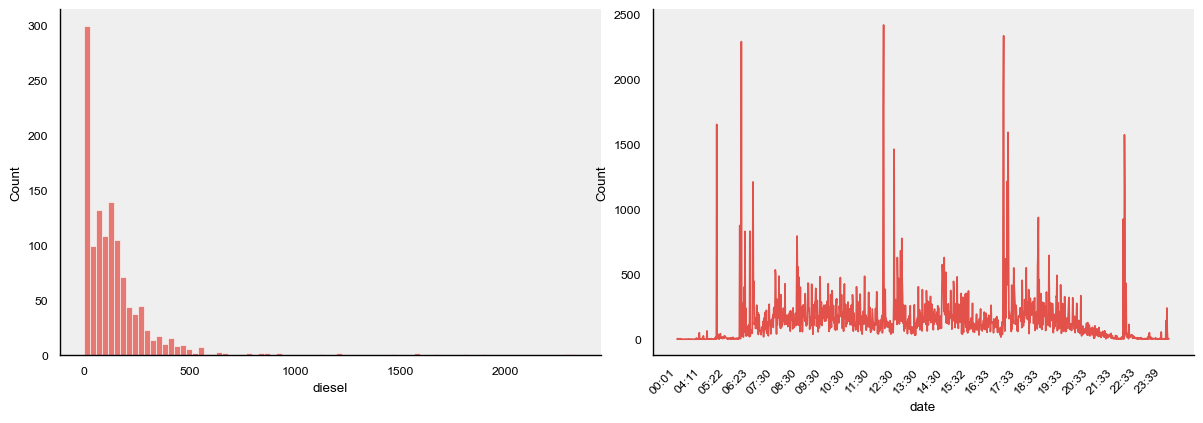

In [20]:
print(f'Number of changes before the mass-prompt: {len(prices_sample[:(rn_timestamps[0] - tdelta)])}')
print(f'Amount of values that changed only when they were prompted: {len(merged_diffs)}')

# creating a table that counts how many price changes occur at each timestamp
reports_per_timestamp = prices_sample.groupby(level='date').count().diesel.sort_values(ascending=False)
print('\n10 timestamps with most frequent reports:')
print(reports_per_timestamp.head(10).values)

print(f'Reports per timestamp \nmean: {reports_per_timestamp.mean().round(2)} \nmedian: {reports_per_timestamp.median()}')

set_rc_params(front_color='black', bg_color='#efefef')
plt.rcParams['grid.alpha'] = 0.0
figure, axis = plt.subplots(1, 2, figsize=(12, 4))
figure.tight_layout()
# excluding the 15.000 event as it's not representetive for actual price changes
sns.histplot(reports_per_timestamp[1:], ax=axis[0]);

# time-series plot of the frequency of all price-change events
counts = prices_sample.groupby(level='date').count().diesel.reset_index()
counts.date = counts.date.apply(lambda x: x.strftime('%H:%M'))
sns.lineplot(counts, x='date', y='diesel', ax=axis[1]);
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(24))
figure.patch.set_alpha(0.0)

plt.show()


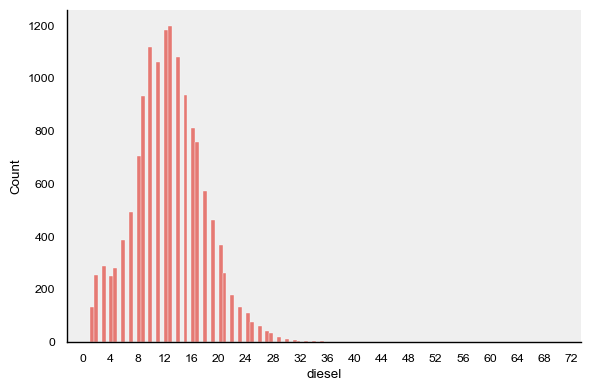

In [21]:
figure, axis = plt.subplots(figsize=(6, 4))

plt.rcParams['grid.alpha'] = 0.0
# time-series plot of the frequency of all price-change events
sns.histplot(prices_sample.groupby('station').count().diesel, ax=axis);
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(24))

figure.patch.set_alpha(0.0)
figure.tight_layout()
plt.show()
set_rc_params()

So, obviously, it is a massive outlier. And even if we reduced these ~15,000 changes down to only 6245 *actual* changes it would still be the biggest outlier by far, with the second biggest batch having a little over 3000 observations
> **This introduces a significant bias to a potential prediction. Unfortunately there is nothing we can really do about a data corruption like this. The performance of a prediction would just be measured against other corrupted data, as this measurement error is systemic. Gas stations are changing their prices constantly, but some of them do not report them in time Data only updates when they get prompted by the global API. The API in return attributes these measurements to a singular timestamp as it can't tell retrospectively when the price change was actually done**

We should definitely not forget about this and eventually find a solution later. What we can do for now is converting the '3's to '0's and '1's where the price didn't change and changed respectively.

### Price Removals and other new prices

We found some other instances were prices were removed and newly added. Down below you see how these might look like. The first two entries are from the same individual. A price has been removed from the list only to add a new price two minutes later. This is basically a price change that can be cleaned. Let's see if this happens more often and develop an algorithm to solve it.

In [22]:
# Let's first remove our mass prompt from the data to have a cleaner DataFrame to work on
removals_df = remove_new.drop(rn_timestamps, level='date')

# We learned from the previous section, that a new price (change==3) can be two things, a price change and an empty prompt. But what about price removals?
removals_df = removals_df.query('dieselchange==2 or e5change==2 or e10change==2')

#lets retrieve the timestamps before and after that and figure out what the stations are doing here
removals_timestamps = removals_df.index.get_level_values('date')
before_removals = timestamps.shift(1).loc[removals_timestamps]
after_removals = timestamps.shift(-1).loc[removals_timestamps]



# and reduce the dataset to the stations of interest
def get_unique_index(df, ind):
    return df.index.get_level_values(ind).unique()

def search_by_index(df, ind, list_of_indices)->pd.DataFrame:
    mask = df.index.get_level_values(ind).isin(list_of_indices)
    return df[mask]


# unique_indices = df.index.get_level_values(ind).unique()
r_stations = get_unique_index(removals_df, 'station')

prices_sample_removals = search_by_index(prices_sample, 'station', r_stations)

before = search_by_index(prices_sample_removals, 'date', before_removals)
removals = search_by_index(prices_sample_removals, 'date', removals_timestamps)
after = search_by_index(prices_sample_removals, 'date', after_removals)




In [23]:
prices_sample

diesel  ...  e10change
date                      station                                       ...           
2018-02-05 00:01:06+01:00 a1e15688-663a-42da-86b3-0501597bcab7   1.168  ...          1
2018-02-05 00:03:05+01:00 00060711-0001-4444-8888-acdc00000001   1.154  ...          0
                          22657dcc-b9e5-4122-8bc8-7daa12222893   1.199  ...          1
                          42d6d4cc-6909-45fc-f60f-a1abd9ea1f0e   1.229  ...          1
                          67299f58-98d9-4b3b-b0d1-fd1da71118a5   1.209  ...          1
...                                                                ...  ...        ...
2018-02-05 23:59:06+01:00 19cfab3d-7c22-4fbd-a19b-fdd8d6a524b1   1.209  ...          0
                          60dbe7f4-89e7-4ef7-2208-919e94a0af24   1.209  ...          0
                          abe9217c-d765-4b63-724e-1b3dcfb7b113   1.219  ...          1
                          ceef3540-a084-42d2-90a5-18f8ddddf495   1.209  ...          1
                          dde0c675-601d-4a00-b7bf-359163df3cac   1.179  ...          0

[180024 rows x 6 columns]

## Daily Patterns

In the following we are trying to investigate whether there are repeating daily patterns in the price changes. For that, the first thing we do is aggregate one day down to only timestamps

In [24]:
np.random.seed(RSEED)
# loading a subset of stations for the Düsseldorf area
dus_stations = pd.read_csv(SAMPLE_DIR / 'stations' / 'stations_dus_plus.csv')

agg_dict = {
        'diesel': 'mean',
        'e5': 'mean',
        'total_changes': 'count'
        }

def my_method(df):
    df = df.filter(['date','station_uuid', 'diesel', 'e5'])
    df = df[(df[['diesel','e5']]>0).all(axis=1)]
    df = pp.resample_timestamps(df, agg_dict, date='date', individual='station_uuid', freq='H')
    df = df.reset_index(level=0).drop('station_uuid', axis=1)
    df = df.groupby('date').mean()
    df['diesel_change'] = np.log(df['diesel']) - np.log(df['diesel'].shift(1))
    df['diesel_daily_change'] = df['diesel'].transform(lambda x: np.log(x) - np.log(x.iloc[0]))
    df['e5_change'] = np.log(df['e5']) - np.log(df['e5'].shift(1))
    df['e5_daily_change'] = df['e5'].transform(lambda x: np.log(x) - np.log(x.iloc[0]))

    df = df.fillna(0)
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df.index = df.index.map(lambda dt: dt.replace(year=2000, month=1, day=1))
    return df

def set_up_axis(ax, col, percent_col=range(10)):
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.tick_params(axis='x', rotation=45)
    if col in percent_col:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel('')

def set_x_labels(fig, labels):
    # Flatten the array of axes and loop through it and the labels at the same time
    for ax, label in zip(fig.axes, labels):
        ax.set_xlabel(label)

weekday_colors = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'indigo',
    6: 'violet'
}

First, we're only looking at the Düsseldorf-subset that we're mostly working with to reduce the data size and take a sample of 200 randomly selected days to see if there is any pattern in them. The method defined above resamples the daily data to equidistant timestamps of hourly data from 00:00 to 00:00 of each days and sets their day to the 1st of January 2000 as a dummy date to plot everything in the same place. We then construct hourly log-differences with one lag to see if there is a pattern in how prices change on an hourly basis.

In [25]:
sample_list = []
np.random.seed(RSEED)

# Creating a new couple processor objects with the subset filter and plotting them all
daily = PriceProcessor(PRICES_DIR, SAMPLE_DIR, subset=dus_stations, subset_df_column='uuid', subset_column='station_uuid') 
for seed in np.random.randint(0, 1001, size=200):
    daily.get_sample(random_state=seed)
    daily.set_method(my_method)
    daily.process_data(daily.sample)
    sample_list.append(daily.last_processed)

sample_concat = pd.concat(sample_list)
sample_concat.groupby(sample_concat.index).mean().head(5)

diesel        e5  ...     month         year
date                                           ...                       
2000-01-01 00:00:00+01:00  1.353174  1.521255  ...  5.915000  2018.635000
2000-01-01 01:00:00+01:00  1.353213  1.521224  ...  5.915000  2018.635000
2000-01-01 02:00:00+01:00  1.351603  1.519675  ...  5.929648  2018.613065
2000-01-01 03:00:00+01:00  1.352932  1.520937  ...  5.915000  2018.635000
2000-01-01 04:00:00+01:00  1.353402  1.521514  ...  5.915000  2018.635000

[5 rows x 10 columns]

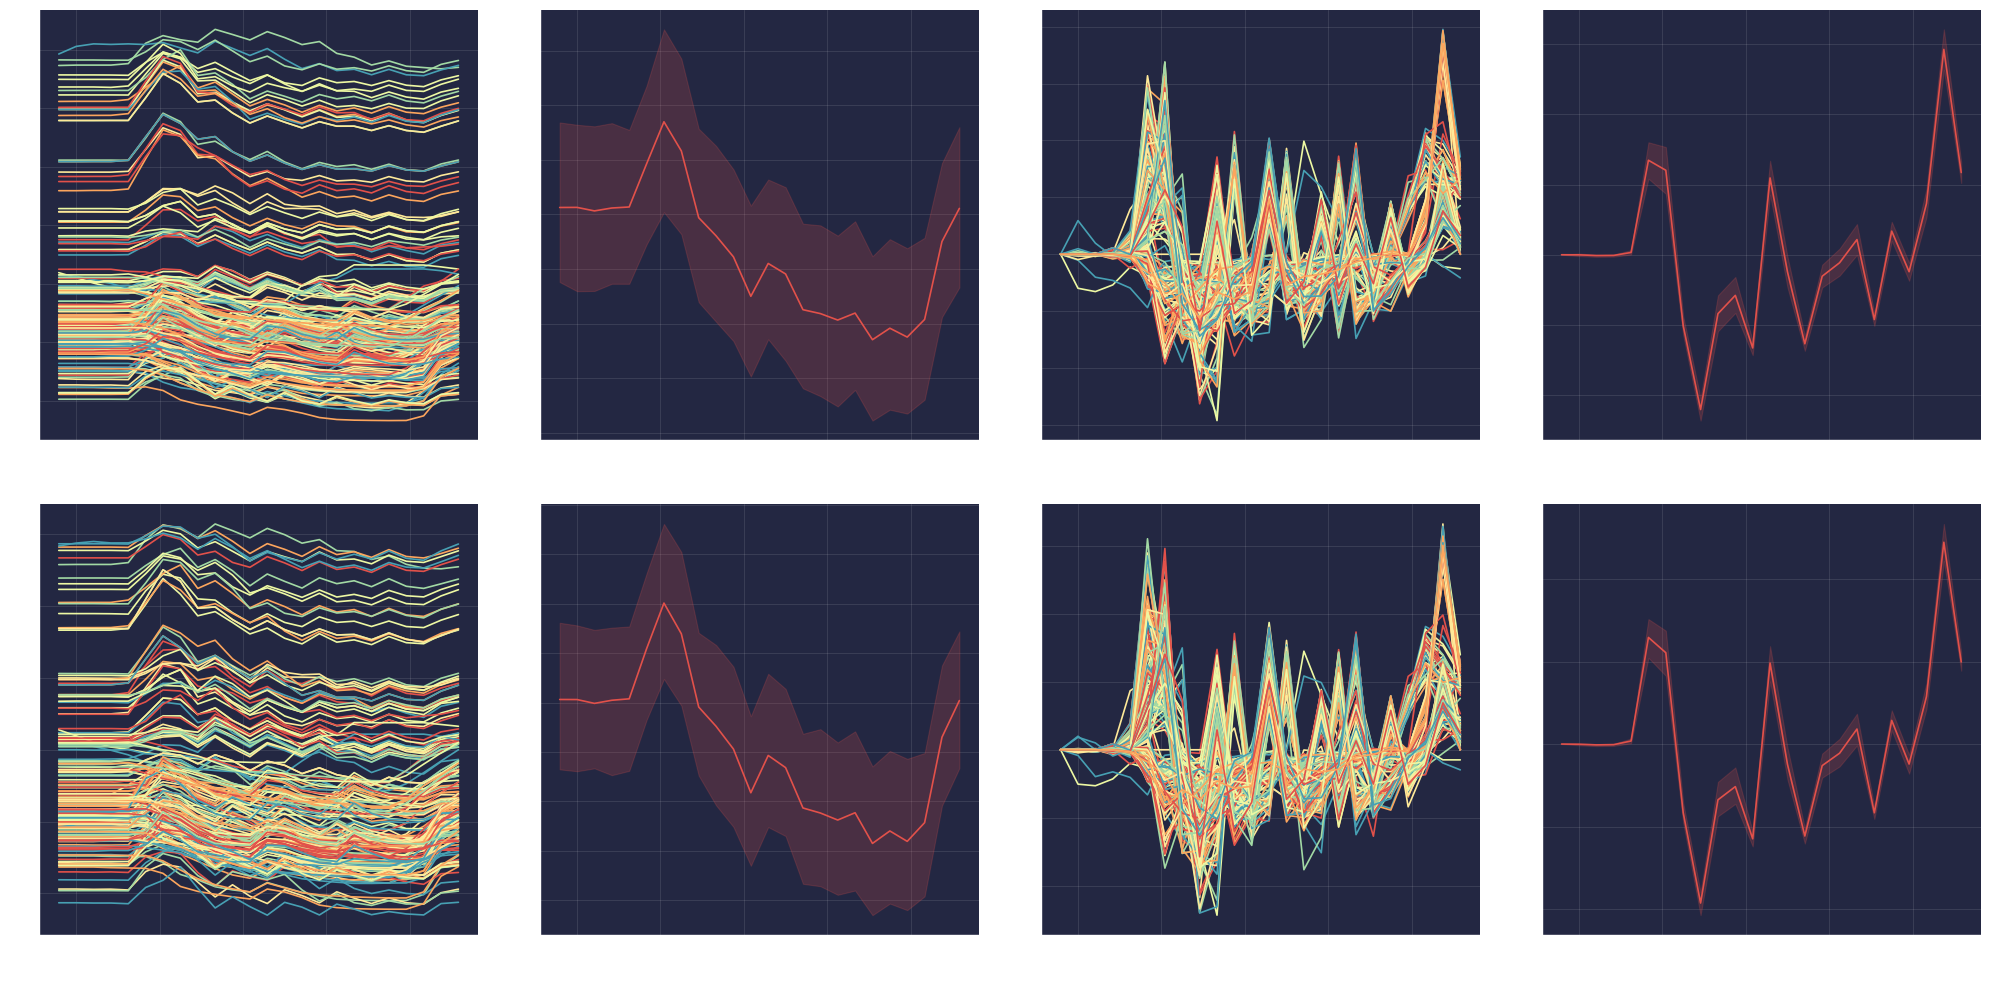

In [26]:
figure, ax = plt.subplots(2, 4, figsize=(20,10))

# Arrange the plots according to your desired layout
plots = [['diesel', 'diesel_change'], ['e5', 'e5_change']]

for row, row_plots in enumerate(plots):
    for col, plot in enumerate(row_plots):
        for sample in sample_list:
            weekday = sample['day_of_week'].iloc[0]
            sns.lineplot(data=sample, x=sample.index, y=plot, ax=ax[row, col*2]) #, color=weekday_colors[weekday]
            set_up_axis(ax[row, col*2], col*2, percent_col=[2,3])

        sns.lineplot(data=sample_concat, x=sample_concat.index, y=plot, ax=ax[row, col*2+1])
        set_up_axis(ax[row, col*2+1], col*2+1, percent_col=[2,3])

x_labels = [
    'Diesel Prices on Sample Days in Euro', 'Aggregated Diesel Prices per day in Euro', 'Change of Diesel Prices on Sample Days in %', 'Aggregated Change of Diesel Prices per day in %',
    'E5 Super Prices on Sample Days in Euro', 'Aggregated E5 Super Prices per day in Euro', 'Change of E5 Super Prices on Sample Days in %', 'Aggregated Change of E5 Super Prices per day in %',]
set_x_labels(figure, x_labels)


plt.rcParams['grid.alpha'] = 0.1
figure.patch.set_alpha(0.0)
plt.tight_layout()  # Ensures subplots do not overlap
plt.show()

In [27]:
figure, ax = plt.subplots(2, 2, figsize=(12,10))

# Arrange the plots according to your desired layout
plots = [['diesel_daily_change'], ['e5_daily_change']]

for row, row_plots in enumerate(plots):
    for col, plot in enumerate(row_plots):
        for sample in sample_list:
            weekday = sample['day_of_week'].iloc[0]
            sns.lineplot(data=sample, x=sample.index, y=plot, ax=ax[row, col*2]) #, color=weekday_colors[weekday]
            set_up_axis(ax[row, col*2], col*2)

        sns.lineplot(data=sample_concat, x=sample_concat.index, y=plot, ax=ax[row, col*2+1])
        set_up_axis(ax[row, col*2+1], col*2+1)

x_labels = [
    'Change of Diesel Prices on Sample Days in %', 'Aggregated Change of Diesel Prices per day in %',
    'Change of E5 Super Prices on Sample Days in %', 'Aggregated Change of E5 Super Prices per day in %',]
set_x_labels(figure, x_labels)

plt.rcParams['grid.alpha'] = 0.1
figure.patch.set_alpha(0.0)
plt.tight_layout()  # Ensures subplots do not overlap
plt.show()

Just to confirm that this isn't a regional oddity, we take the same sample of 200 days but don't aggregate the data from a single city but from the entire republic to see if there are any differences.

In [28]:
sample_list = []
np.random.seed(RSEED)

# Creating a new couple processor objects with the subset filter and plotting them all
daily = PriceProcessor(PRICES_DIR, SAMPLE_DIR) 
for seed in np.random.randint(0, 1001, size=200):
    daily.get_sample(random_state=seed)
    daily.set_method(my_method)
    daily.process_data(daily.sample)
    sample_list.append(daily.last_processed)

sample_concat = pd.concat(sample_list)
sample_concat.groupby(sample_concat.index).mean().head(5)

diesel        e5  ...     month         year
date                                           ...                       
2000-01-01 00:00:00+01:00  1.352610  1.516402  ...  5.915000  2018.635000
2000-01-01 01:00:00+01:00  1.352522  1.516355  ...  5.915000  2018.635000
2000-01-01 02:00:00+01:00  1.350809  1.514834  ...  5.929648  2018.613065
2000-01-01 03:00:00+01:00  1.352370  1.516244  ...  5.915000  2018.635000
2000-01-01 04:00:00+01:00  1.352563  1.516571  ...  5.915000  2018.635000

[5 rows x 10 columns]

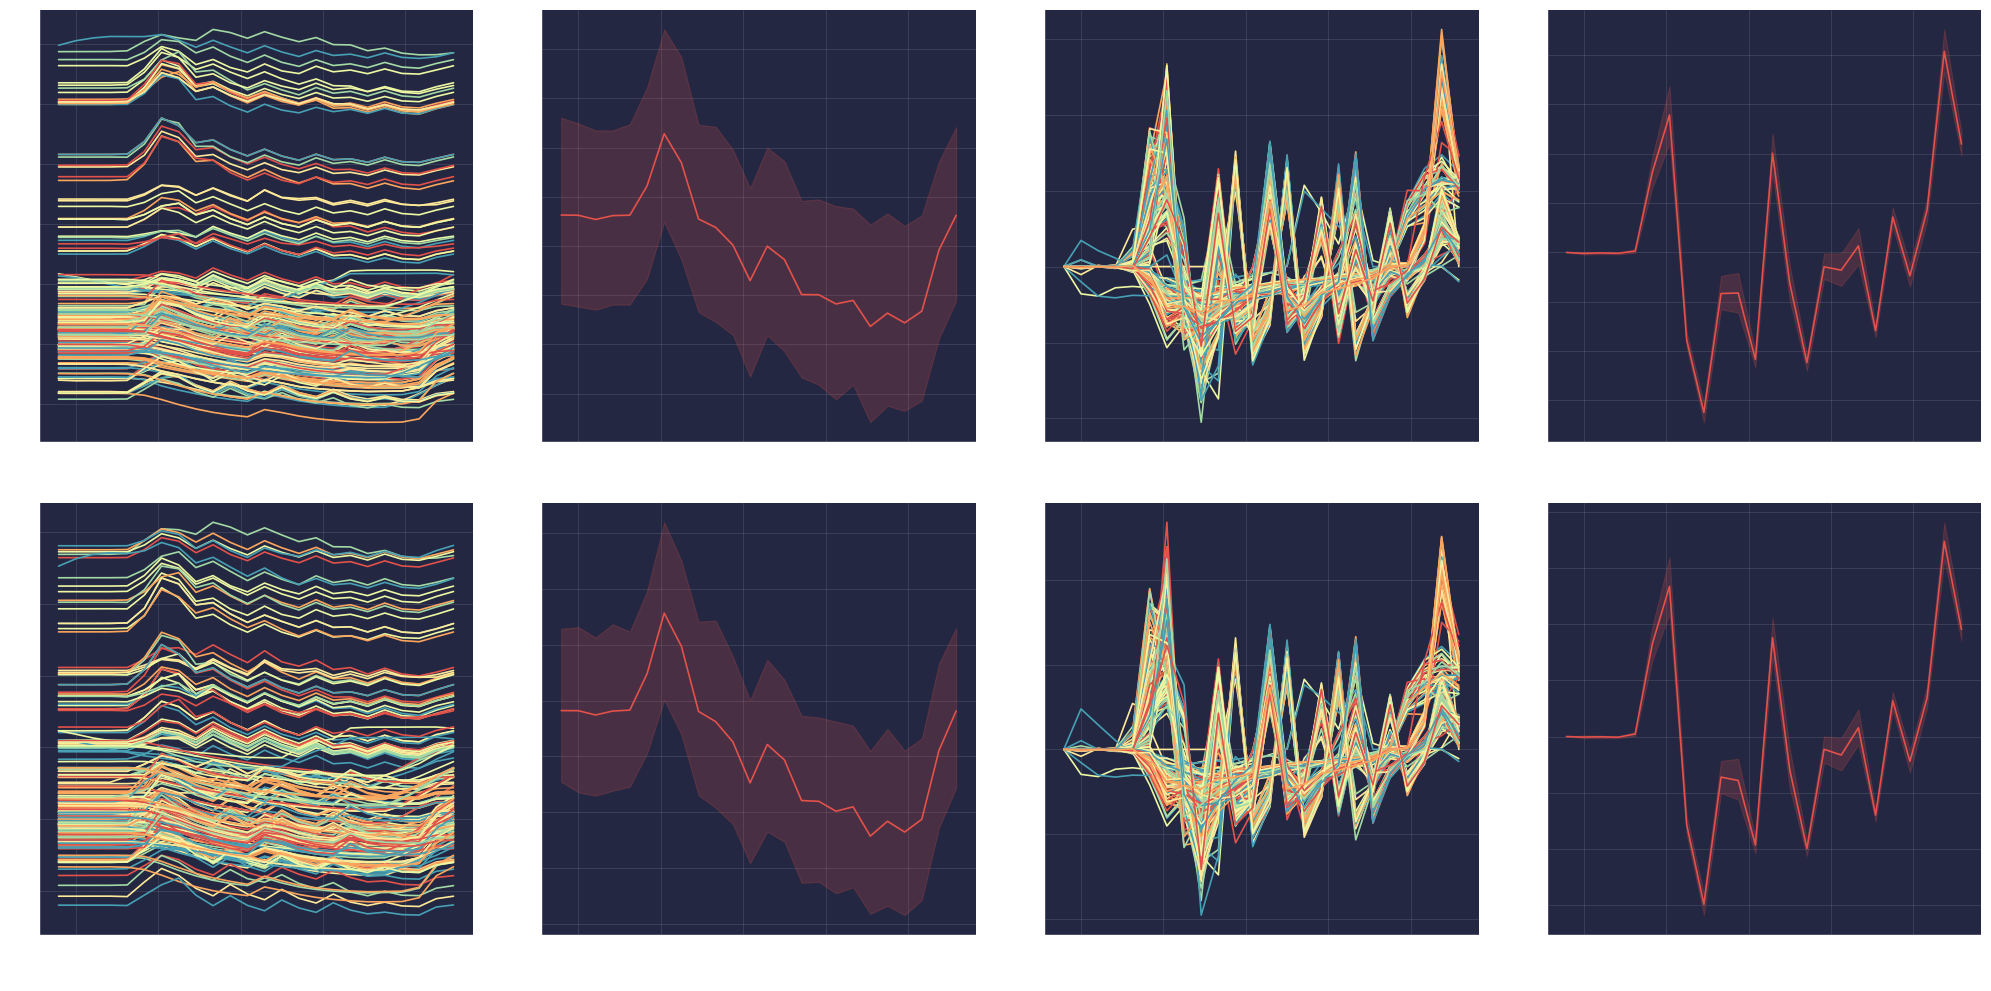

In [29]:
figure, ax = plt.subplots(2, 4, figsize=(20,10))

# Arrange the plots according to your desired layout
plots = [['diesel', 'diesel_change'], ['e5', 'e5_change']]

for row, row_plots in enumerate(plots):
    for col, plot in enumerate(row_plots):
        for sample in sample_list:
            sns.lineplot(data=sample, x=sample.index, y=plot, ax=ax[row, col*2])
            set_up_axis(ax[row, col*2], col*2, percent_col=[2,3])


        sns.lineplot(data=sample_concat, x=sample_concat.index, y=plot, ax=ax[row, col*2+1])
        set_up_axis(ax[row, col*2+1], col*2+1, percent_col=[2,3])

x_labels = [
    'Diesel Prices on Sample Days in Euro', 'Aggregated Diesel Prices per day in Euro', 'Change of Diesel Prices on Sample Days in %', 'Aggregated Change of Diesel Prices per day in %',
    'E5 Super Prices on Sample Days in Euro', 'Aggregated E5 Super Prices per day in Euro', 'Change of E5 Super Prices on Sample Days in %', 'Aggregated Change of E5 Super Prices per day in %',]
set_x_labels(figure, x_labels)


plt.rcParams['grid.alpha'] = 0.1
figure.patch.set_alpha(0.0)
plt.tight_layout()  # Ensures subplots do not overlap
plt.show()

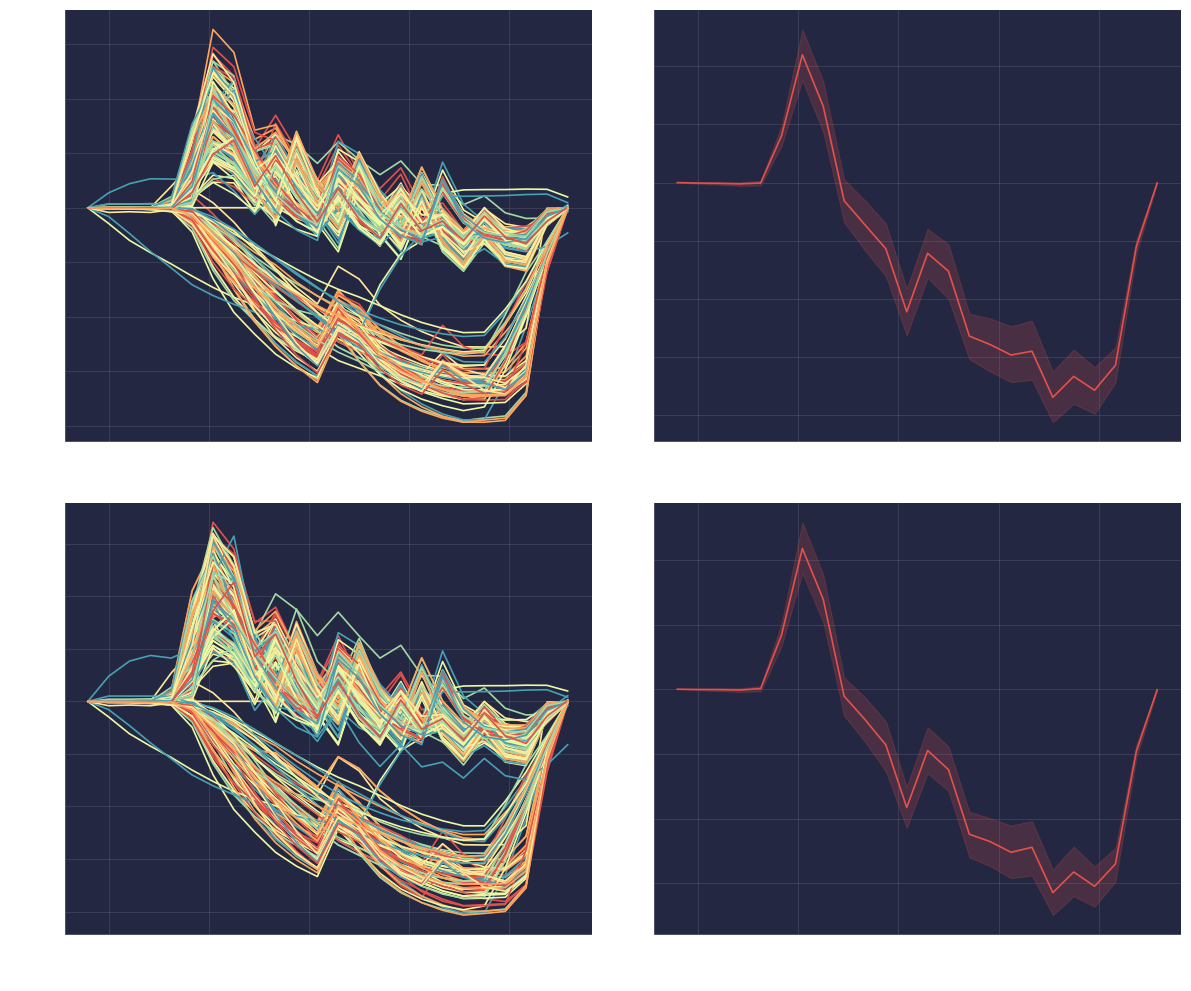

In [30]:
figure, ax = plt.subplots(2, 2, figsize=(12,10))

# Arrange the plots according to your desired layout
plots = [['diesel_daily_change'], ['e5_daily_change']]

for row, row_plots in enumerate(plots):
    for col, plot in enumerate(row_plots):
        for sample in sample_list:
            sns.lineplot(data=sample, x=sample.index, y=plot, ax=ax[row, col*2])
            set_up_axis(ax[row, col*2], col*2)

        sns.lineplot(data=sample_concat, x=sample_concat.index, y=plot, ax=ax[row, col*2+1])
        set_up_axis(ax[row, col*2+1], col*2+1)

x_labels = [
    'Change of Diesel Prices on Sample Days in %', 'Aggregated Change of Diesel Prices per day in %',
    'Change of E5 Super Prices on Sample Days in %', 'Aggregated Change of E5 Super Prices per day in %',]
set_x_labels(figure, x_labels)

plt.rcParams['grid.alpha'] = 0.1
figure.patch.set_alpha(0.0)
plt.tight_layout()  # Ensures subplots do not overlap
plt.show()

We can see a very clear divide between days. Some days the price bumps up at first and some times the price goes down. So far this is nothing surprising but there might be a pattern behind this. One explanation could be that on weekdays prices change differently than on business days.

In [31]:
resampled_diesel_dir = ROOT_DIR / 'resampled_prices' / 'diesel'
resampled_e5_dir = ROOT_DIR / 'resampled_prices' / 'e5'

resampled = PriceProcessor(resampled_diesel_dir, SAMPLE_DIR)
resampled_list = []
test = []
np.random.seed(RSEED)

stations = resampled.get_sample(random_state=seed).station.unique()
df = process.swap_sort_index(process.set_panel_index(resampled.sample, individual='station'))
df = df[(df[['diesel']]>0).all(axis=1)]

df['diesel_change'] = df.groupby(level='station')['diesel'].apply(lambda x: np.log(x) - np.log(x.shift(1)))#.reset_index(level=0, drop=True)


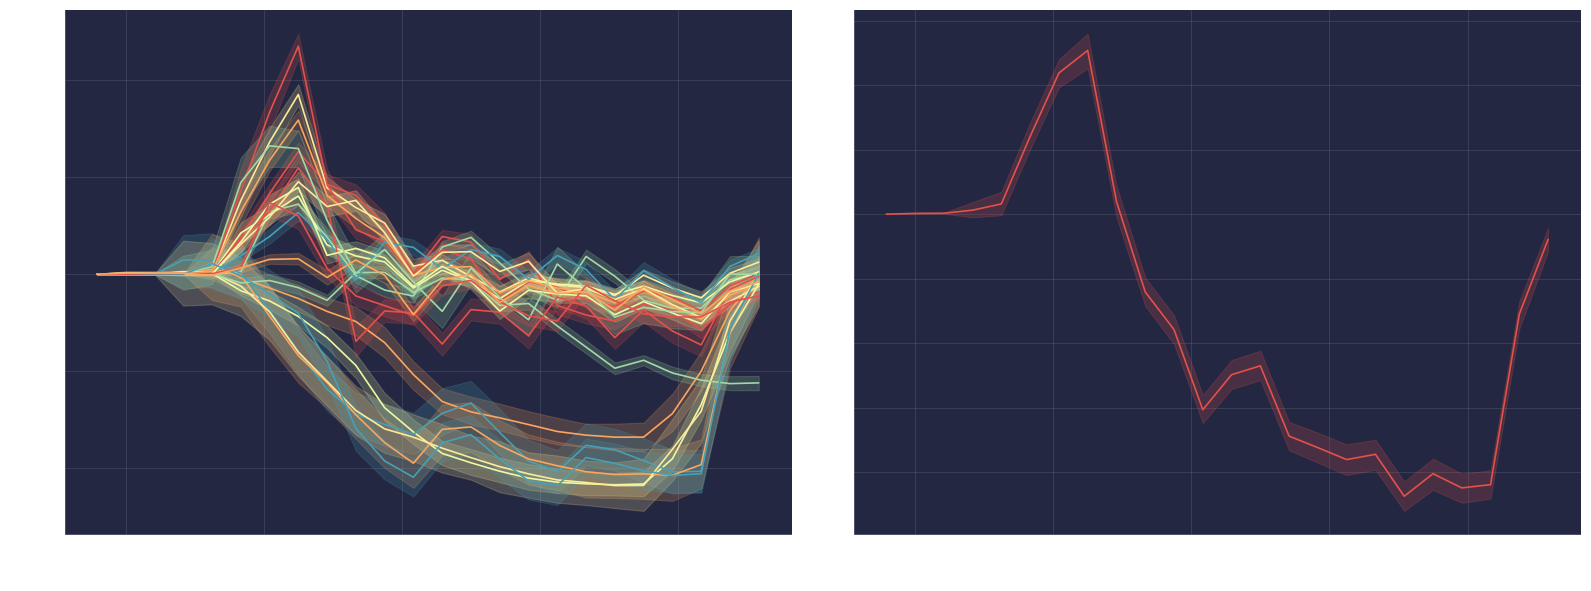

In [32]:
resampled_diesel_dir = ROOT_DIR / 'resampled_prices' / 'diesel'
resampled_e5_dir = ROOT_DIR / 'resampled_prices' / 'e5'

resampled = PriceProcessor(resampled_diesel_dir, SAMPLE_DIR)
resampled_list = []
test = []
np.random.seed(RSEED)

figure, ax = plt.subplots(1, 2, figsize=(16,6))
for seed in np.random.randint(0, 1001, size=20):
    stations = resampled.get_sample(random_state=seed).station.unique()
    df = process.swap_sort_index(process.set_panel_index(resampled.sample, individual='station'))
    df = df[(df[['diesel']]>0).all(axis=1)]
    df['diesel_change'] = df.groupby(level='station')['diesel'].apply(lambda x: np.log(x) - np.log(x.shift(1)))#.reset_index(level=0, drop=True)
    df['diesel_daily_change'] = df.groupby(level='station')['diesel'].apply(lambda x: np.log(x) - np.log(x.iloc[0]))#.reset_index(level=0, drop=True)
    df = df.fillna(0)
    df = df.reset_index(level='date')
    test.append(df.copy())
    df['date'] = df['date'].apply(lambda dt: dt.replace(year=2000, month=1, day=1))
    df = df.set_index('date', append=True).sort_index()
    df = df.reset_index(level='station').drop('station', axis=1)
    sns.lineplot(data=df, x='date', y='diesel_daily_change', ax=ax[0])
    set_up_axis(ax[0], col*2)
    resampled_list.append(df)

resampled_concat = pd.concat(resampled_list)
sns.lineplot(data=resampled_concat, x='date', y='diesel_daily_change', ax=ax[1]);
set_up_axis(ax[1], col*2+1)

x_labels = ['Change of Diesel Prices on Sample Days in %', 'Aggregated Change of Diesel Prices per day in %']
set_x_labels(figure, x_labels)

plt.rcParams['grid.alpha'] = 0.1
figure.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()

In [33]:
remerged = pd.read_csv('resampled_prices/merged/diesel.csv')
remerged = process.swap_sort_index(process.set_panel_index(remerged, individual='station'))

In [34]:
remerged = remerged.assign(
    hourly_diff = remerged.groupby('station')['diesel']
                        .apply(lambda group: np.log(group).diff())
                        #.reset_index(level=0, drop=True)
                        ,
    daily_diff = remerged.groupby('station')['diesel']
                        .apply(lambda group: np.log(group).diff(24))
                        #.reset_index(level=0, drop=True)
                        ,
    weekly_diff = remerged.groupby('station')['diesel']
                        .apply(lambda group: np.log(group).diff(24*7))
                        #.reset_index(level=0, drop=True)
                        ,
    year = remerged.index.get_level_values('date').year,
    day_date = remerged.index.get_level_values('date').dayofyear,
    day_of_week = remerged.index.get_level_values('date').day_name(),
    day_time = remerged.index.get_level_values('date').hour,
).dropna()

In [35]:
remerged

diesel  ...  day_time
station                              date                                 ...          
00041414-208c-4444-8888-acdc00000414 2015-04-02 00:00:00+02:00  1.139000  ...         0
                                     2015-04-02 01:00:00+02:00  1.139000  ...         1
                                     2015-04-02 02:00:00+02:00  1.139000  ...         2
                                     2015-04-02 03:00:00+02:00  1.139000  ...         3
                                     2015-04-02 04:00:00+02:00  1.139000  ...         4
...                                                                  ...  ...       ...
ff55d404-3609-48b2-b16a-ef4a9f2008a0 2023-06-07 19:00:00+02:00  1.531857  ...        19
                                     2023-06-07 20:00:00+02:00  1.527864  ...        20
                                     2023-06-07 21:00:00+02:00  1.509000  ...        21
                                     2023-06-07 22:00:00+02:00  1.509000  ...        22
                                     2023-06-07 23:00:00+02:00  1.509000  ...        23

[8684759 rows x 10 columns]

In [38]:
# get a randomly sampled station uuid with a reproducable method
random_station = remerged.sample(random_state=seed).index.get_level_values('station')[0]

# Define the correct order for the days of the week and sort to have a proper legend
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
remerged['day_of_week'] = pd.Categorical(remerged['day_of_week'], categories=day_order, ordered=True)
remerged.sort_values('day_of_week', inplace=True)


# Figure
set_rc_params()
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(remerged, x='day_time', y='daily_diff', hue='day_of_week', palette='Spectral', ax=ax) #.query('station == @random_station')
plt.xticks(remerged['day_time'].unique())
ax.xaxis.set_major_locator(mtick.MaxNLocator(12))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set_xlabel('Difference of Diesel Price compared to 24 Hours ago in %')
ax.set_ylabel('')

set_plot_options(fig, ax)
plt.show()

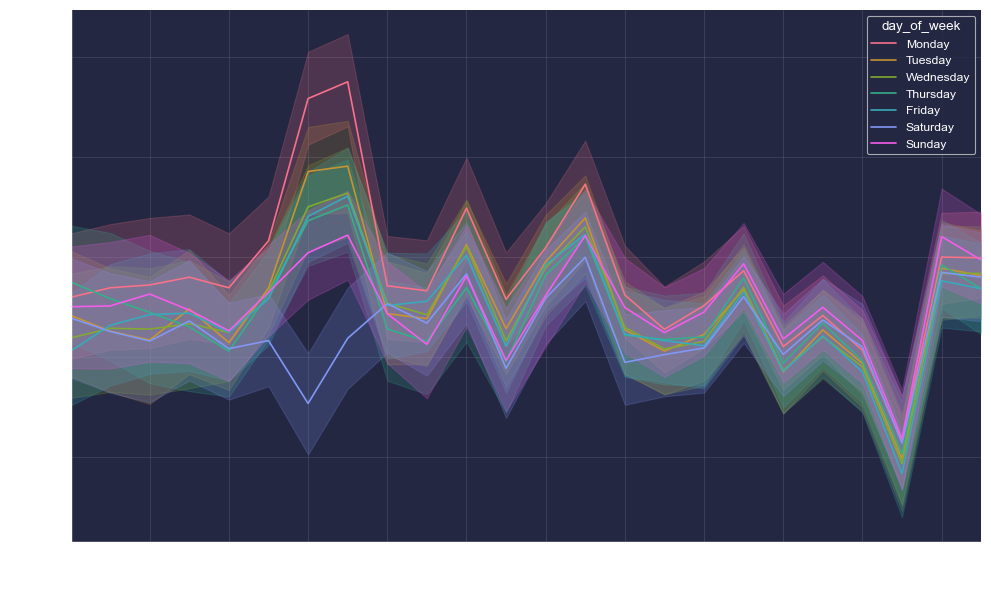

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(remerged, x='day_time', y='weekly_diff', hue='day_of_week', ax=ax)
plt.xticks(remerged['day_time'].unique())
ax.xaxis.set_major_locator(mtick.MaxNLocator(12))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set_xlabel('Difference of Diesel Price compared to 7 Days ago in %')
ax.set_ylabel('')

set_plot_options(fig, ax)
plt.show()

In [40]:
meta = pd.read_csv('data_processed/meta/prices_metadata.csv')
meta.date = pd.to_datetime(meta.date)
meta.set_index('date', inplace=True)

oil = pd.read_csv('data_processed/meta//fill_crude_oil_2014_2023.csv')
oil.date = pd.to_datetime(oil.date)
oil.set_index('date', inplace=True)

meta = pd.DataFrame(meta.diesel_mean)
merged_df = meta.join(oil)
merged_df

merged_df['diesel_change'] = np.log(merged_df['diesel_mean']) - np.log(merged_df['diesel_mean'].shift(1))
merged_df['diesel_t0_change'] = merged_df['diesel_mean'].transform(lambda x: (x / x.iloc[0]) - 1)
merged_df['crude_oil_change'] = np.log(merged_df['crude_oil_price']) - np.log(merged_df['crude_oil_price'].shift(1))
merged_df['crude_oil_t0_change'] = merged_df['crude_oil_price'].transform(lambda x: (x / x.iloc[0]) - 1)
merged_df.dropna()

diesel_mean  crude_oil_price  ...  crude_oil_change  crude_oil_t0_change
date                                      ...                                       
2014-06-09        1.371           110.55  ...          0.003035             0.003040
2014-06-10        1.361           109.18  ...         -0.012470            -0.009391
2014-06-11        1.364           109.83  ...          0.005936            -0.003493
2014-06-12        1.364           112.18  ...          0.021171             0.017829
2014-06-13        1.375           113.15  ...          0.008610             0.026630
...                 ...              ...  ...               ...                  ...
2023-05-06        1.569            76.33  ...          0.006308            -0.307445
2023-05-07        1.540            76.57  ...          0.003139            -0.305267
2023-05-08        1.568            76.81  ...          0.003129            -0.303089
2023-05-09        1.564            77.76  ...          0.012292            -0.294470
2023-05-10        1.595            76.70  ...         -0.013725            -0.304087

[3258 rows x 6 columns]

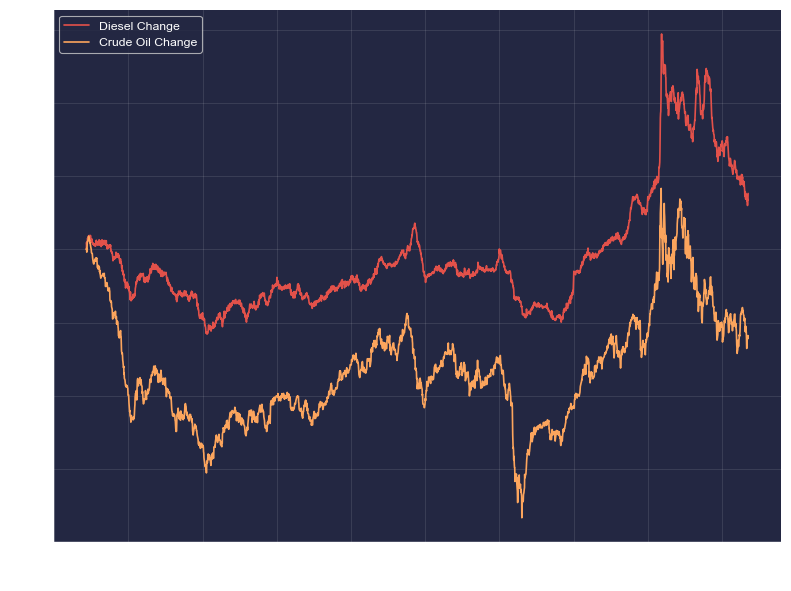

In [41]:
set_rc_params()
plt.rcParams['grid.alpha'] = 0.1
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(data=merged_df, x='date', y='diesel_t0_change', label='Diesel Change', ax=ax)
sns.lineplot(data=merged_df, x='date', y='crude_oil_t0_change', label='Crude Oil Change', ax=ax)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set_xlabel('Change in average Diesel Price vs BRENT Crude Oil Price in %, (2014 base Price)')
ax.set_ylabel('')

plt.legend()
fig.patch.set_alpha(0.0)
plt.tight_layout()  # Ensures subplots do not overlap
plt.show()